In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import shap
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier

## Load the data 🎉😎🧬

In [107]:
notebook_dir = os.getcwd()
print(f"Current notebook directory: {notebook_dir}")
features_file = notebook_dir + '/data/filtered_combined_data.tsv'

# recurrance
features_file = notebook_dir + '/data/filtered_recurrence.tsv'

#labels_file = os.path.join(notebook_dir, '../data/toy_labels.tsv')

features_df = pd.read_csv(features_file, sep='\t', index_col=0)
#labels_df = pd.read_csv(labels_file, sep='\t', index_col=0)

# for task 1:
#labels = pd.Series([0 if col.startswith('N') else 1 for col in features_df.columns], index=features_df.columns)

#for task 2:
# remove last row of features_df
features_df = features_df.iloc[:-1, :]
labels = pd.Series([0 if col.endswith('R') else 1 for col in features_df.columns], index=features_df.columns)

# Convert to DataFrame if needed
labels_df = labels.to_frame(name='label')

Current notebook directory: /Users/deeptimurthy/BENG203


## Set up for cross validation 👁👄👁

In [108]:
SEED = 33
X = features_df.T.loc[labels_df.index]
y = labels_df['label'].values
num_splits = 5
cv = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=SEED)

## Train a Random Forest 🌲🌳📉

In [130]:
# Store results
accuracies = []
shap_values_all = []
explainer = None

for fold, (train_idx, test_idx) in tqdm(enumerate(cv.split(X, y), 1), total=num_splits, desc='Cross-validation'):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]


    # Train model
    #model = KNeighborsClassifier(n_neighbors=5)  # Example model
    model = RandomForestClassifier(random_state=SEED) # change the model here
    #model = LogisticRegression(random_state=SEED, max_iter=1000)  # Example model
    #model = SVC(probability=True, random_state=SEED)  # Example model
    #model = MLPClassifier(random_state=SEED, max_iter=1000)  # Example model
    #model = GradientBoostingClassifier(random_state=SEED, n_estimators=100, learning_rate=0.1, max_depth=3)  # Example model

    model.fit(X_train, y_train)

    # Predict and evaluate
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)
    print(f"Fold {fold} Accuracy: {acc:.4f}")

    # Save metrics for fold one
    if fold == 1:
        # SHAP
        explainer = shap.Explainer(model, X_train)
        shap_values = explainer(X_test)
        shap_values_all.append(shap_values)

        # AUROC
        probs = model.predict_proba(X_test)[:, 1]
        first_fold_y_true = y_test
        first_fold_y_probs = probs

# Summary of performance
print(f"\nMean Accuracy 🫡: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")

Cross-validation:  20%|██        | 1/5 [00:00<00:00,  6.43it/s]

Fold 1 Accuracy: 0.7000
Fold 2 Accuracy: 0.6316


Cross-validation: 100%|██████████| 5/5 [00:00<00:00, 10.22it/s]

Fold 3 Accuracy: 0.6842
Fold 4 Accuracy: 0.7368
Fold 5 Accuracy: 0.7368

Mean Accuracy 🫡: 0.6979 ± 0.0390


## SHAP evaluation 🧐📈⚖️

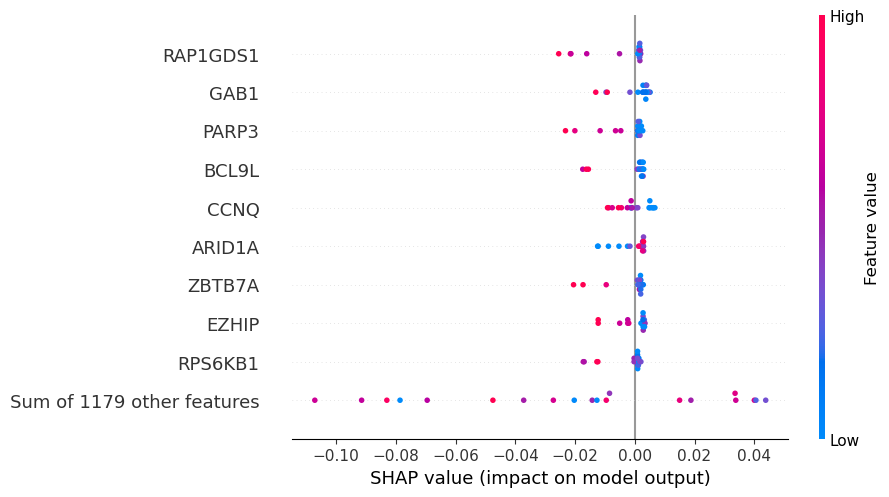

In [131]:
# SHAP summary plot for first fold (class 1 in binary classification)
if shap_values_all:
    shap.plots.beeswarm(shap_values_all[0][:, :, 1])

## AUROC 😱✨⁉️

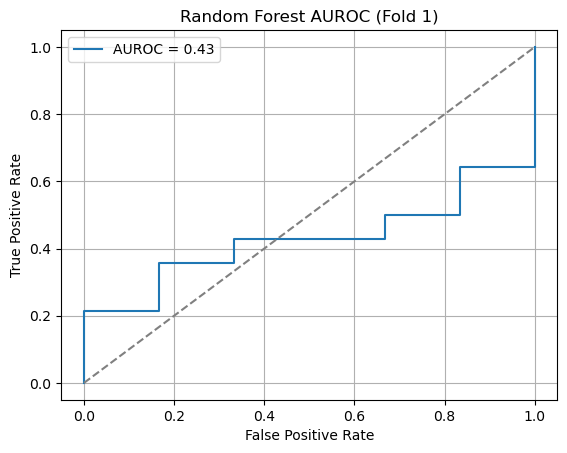

In [125]:
fpr, tpr, _ = roc_curve(first_fold_y_true, first_fold_y_probs)
auc = roc_auc_score(first_fold_y_true, first_fold_y_probs)

plt.figure()
plt.plot(fpr, tpr, label=f'AUROC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest AUROC (Fold 1)')
plt.legend()
plt.grid(True)
plt.show()

In [126]:
print(f"\"probs\": [{', '.join([str(p) for p in probs])}],")
print(f"\"first_fold_y_true\": [{', '.join([str(p) for p in first_fold_y_true])}],")
print(f"\"first_fold_y_probs\": [{', '.join([str(p) for p in first_fold_y_probs])}]")

"probs": [0.06310579252403796, 0.17841827934564394, 0.9372278675982042, 0.0013873070764739068, 0.9814784938966733, 0.9993947561141205, 1.0, 0.15775473148009408, 0.009660295248836642, 0.0387910581228901, 0.987444627312735, 2.037671766903577e-06, 0.9999198937169639, 1.316601341937486e-13, 0.9999056032013258, 0.00039474338290675516, 0.9802450850769462, 0.9992829468254124, 1.2854427177286093e-06, 4.418927142112968e-09],
"first_fold_y_true": [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
"first_fold_y_probs": [0.06310579252403796, 0.17841827934564394, 0.9372278675982042, 0.0013873070764739068, 0.9814784938966733, 0.9993947561141205, 1.0, 0.15775473148009408, 0.009660295248836642, 0.0387910581228901, 0.987444627312735, 2.037671766903577e-06, 0.9999198937169639, 1.316601341937486e-13, 0.9999056032013258, 0.00039474338290675516, 0.9802450850769462, 0.9992829468254124, 1.2854427177286093e-06, 4.418927142112968e-09]
